In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [ ]:
# --- Load and Clean Data ---

In [ ]:

# Load the dataset
data = pd.read_csv(r"C:\Users\RIDEON\Desktop\adult data set'\adult.csv")


In [23]:
data

,age,workclass,fnlwgt,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,34,Private,198693,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43434,27,Private,257302,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
43435,40,Private,154374,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
43436,58,Private,151910,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
43437,22,Private,201490,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [3]:
# Replace '?' with NaN and drop rows with missing essential data
data.replace('?', np.nan, inplace=True)
data.dropna(subset=['workclass', 'occupation', 'native-country'], inplace=True)

In [4]:
# Filter data based on outlier analysis
data = data[(data['age'] <= 75) & (data['age'] >= 17)]
data = data[(data['educational-num'] <= 16) & (data['educational-num'] >= 5)]
data = data.drop(columns=['education'])

In [5]:
# Reset index after dropping rows
data.reset_index(drop=True, inplace=True)

In [ ]:
# --- Exploratory Data Analysis (EDA) with Visualizations ---

In [6]:
# Set plot style
sns.set_style("whitegrid")

C:\Users\RIDEON\AppData\Local\Temp\ipykernel_5760\2485941375.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='income', data=data, palette='viridis')


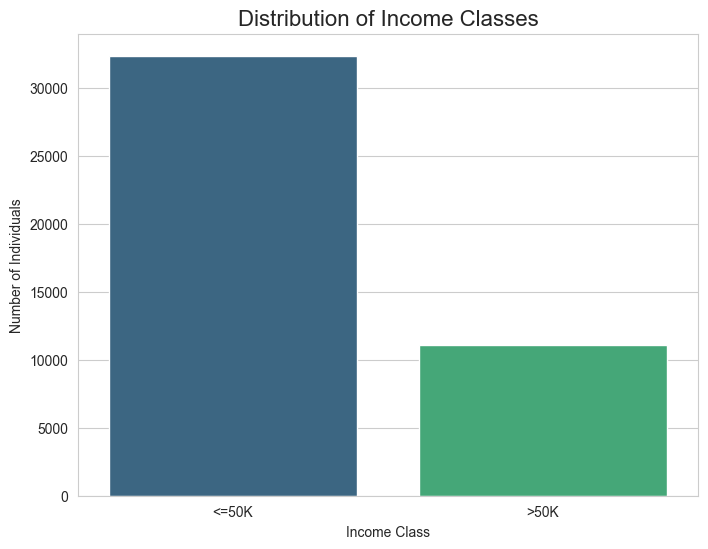

In [7]:
# 1. Distribution of the Target Variable (Income)
plt.figure(figsize=(8, 6))
sns.countplot(x='income', data=data, palette='viridis')
plt.title('Distribution of Income Classes', fontsize=16)
plt.ylabel('Number of Individuals')
plt.xlabel('Income Class')
plt.show()

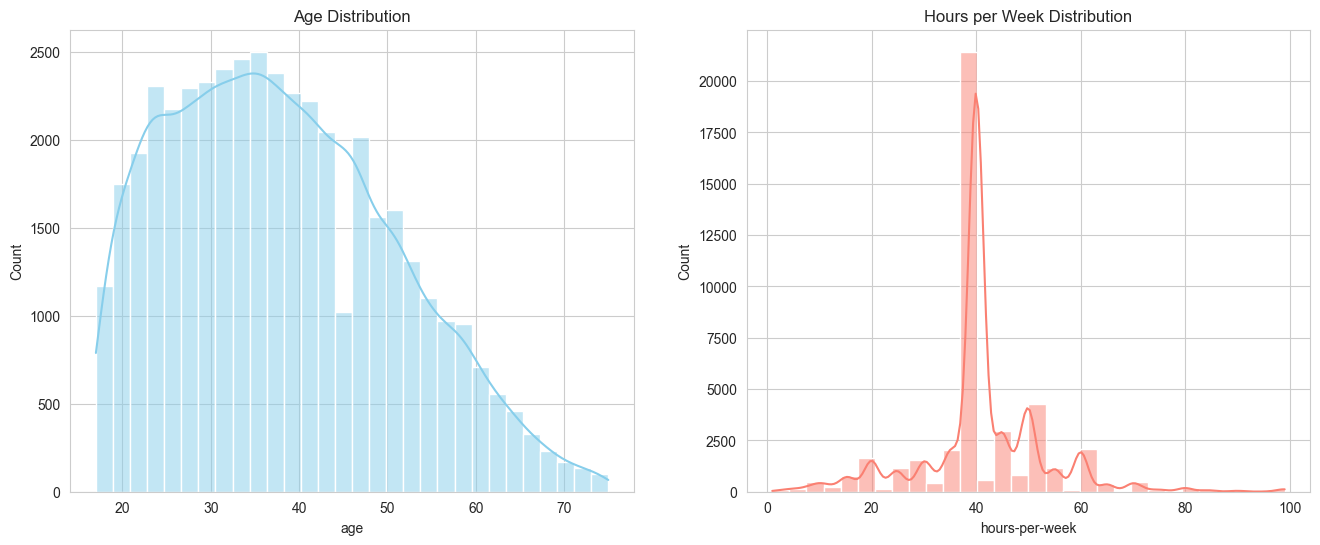

In [8]:
# 2. Distribution of Key Numerical Features
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(data['age'], bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Age Distribution')
sns.histplot(data['hours-per-week'], bins=30, kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Hours per Week Distribution')
plt.show()

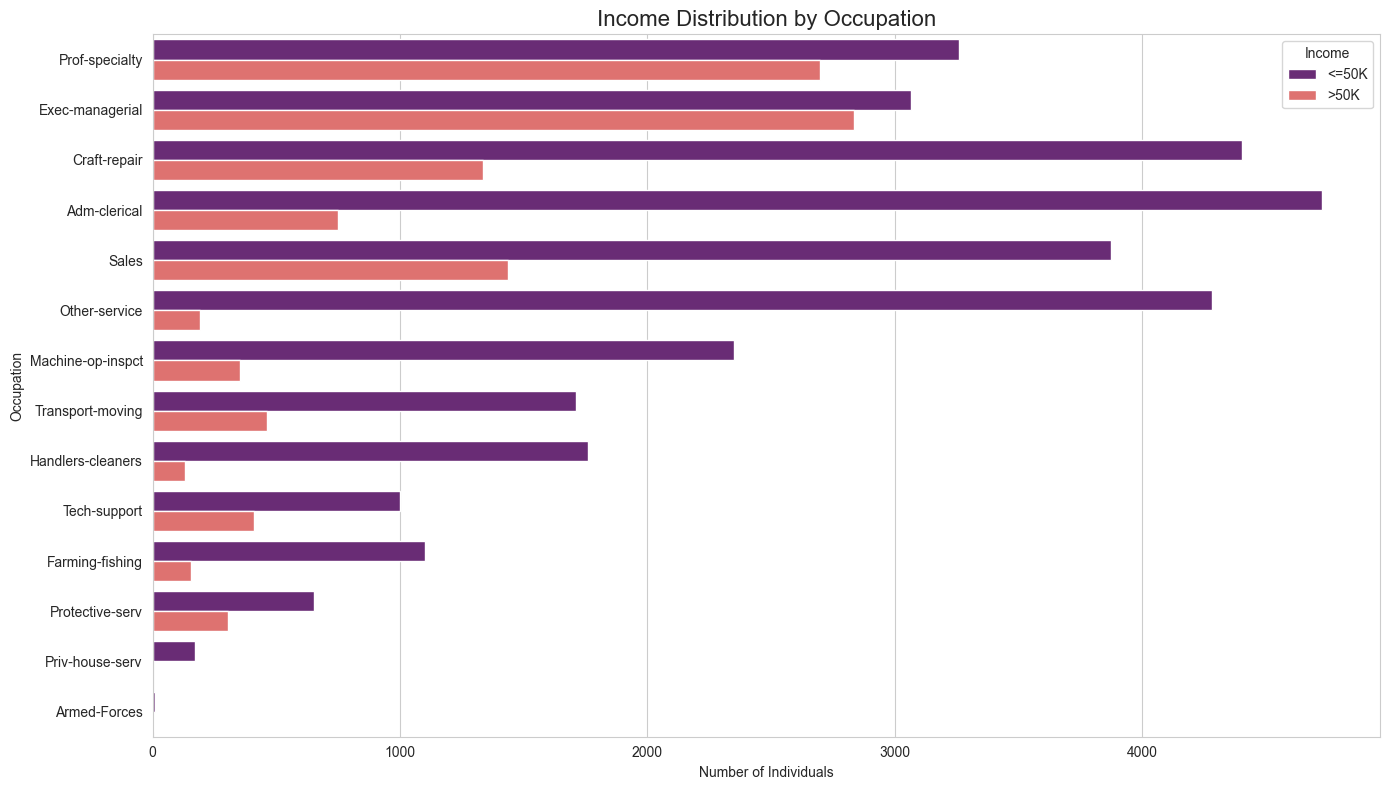

In [9]:
# 3. Income Distribution by Occupation
plt.figure(figsize=(14, 8))
sns.countplot(y='occupation', hue='income', data=data, palette='magma', order=data['occupation'].value_counts().index)
plt.title('Income Distribution by Occupation', fontsize=16)
plt.xlabel('Number of Individuals')
plt.ylabel('Occupation')
plt.legend(title='Income')
plt.tight_layout()
plt.show()

In [10]:
# Separate features (X) and target (y)
X = data.drop('income', axis=1)
y = data['income']

In [11]:
# Identify feature types
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=np.number).columns

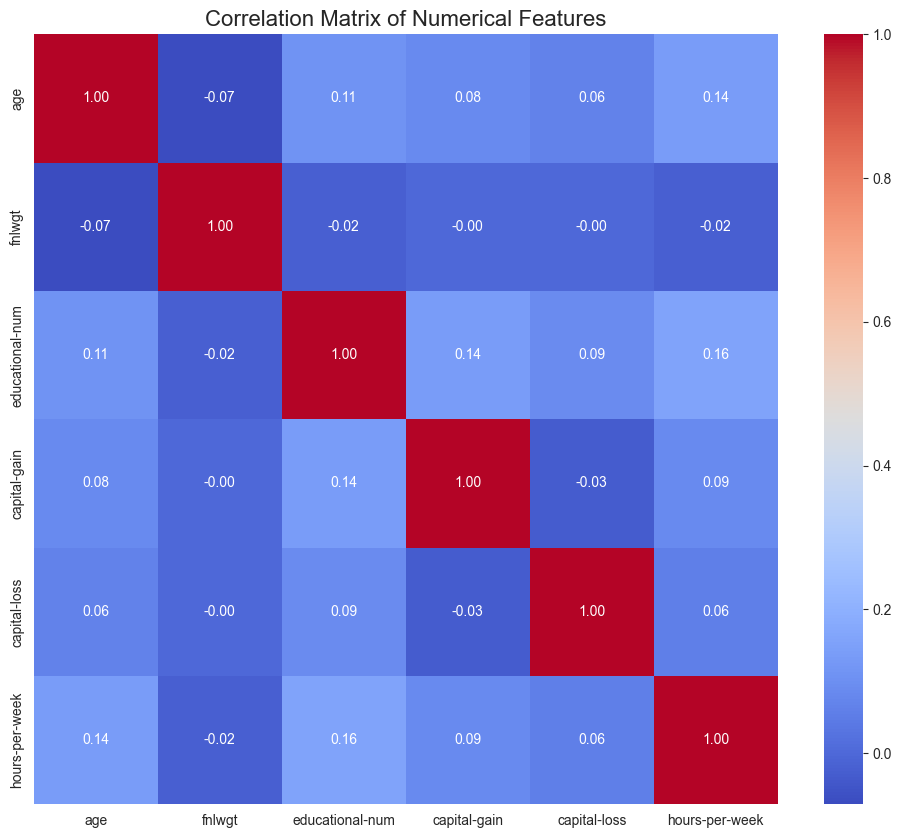

In [12]:
# 4. Correlation Heatmap of Numerical Features
plt.figure(figsize=(12, 10))
correlation_matrix = data[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.show()

In [13]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
# --- Build and Tune the Pipeline ---
# Create a preprocessing pipeline for feature scaling and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)


In [15]:
# Define the full model pipeline with SMOTE for handling class imbalance
pipeline_with_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

In [16]:
# Define the hyperparameter grid
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__max_depth': [3, 4]
}


In [17]:
# Set up and run GridSearchCV
grid_search = GridSearchCV(pipeline_with_smote, param_grid, cv=3, n_jobs=-1, scoring='accuracy', verbose=2)
print("Starting GridSearchCV for GradientBoostingClassifier with SMOTE...")
grid_search.fit(X_train, y_train)

Starting GridSearchCV for GradientBoostingClassifier with SMOTE...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'gender', 'native-country'],
      dtype='object'))])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.05, 0.1],
                         'classifier__max_depth': [3, 4],
                         'classifier__n_estimators': [100, 200]},
             scoring='accuracy', verbose=2)

In [18]:
# --- Evaluate and Save ---
print("\nBest parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(grid_search.best_score_))


Best parameters found:  {'classifier__learning_rate': 0.1, 'classifier__max_depth': 4, 'classifier__n_estimators': 200}
Best cross-validation accuracy: 0.8463


In [20]:
# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\n--- Test Set Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


--- Test Set Evaluation ---
Accuracy: 0.8467

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.92      0.86      0.89      6473
        >50K       0.67      0.79      0.73      2215

    accuracy                           0.85      8688
   macro avg       0.80      0.83      0.81      8688
weighted avg       0.86      0.85      0.85      8688



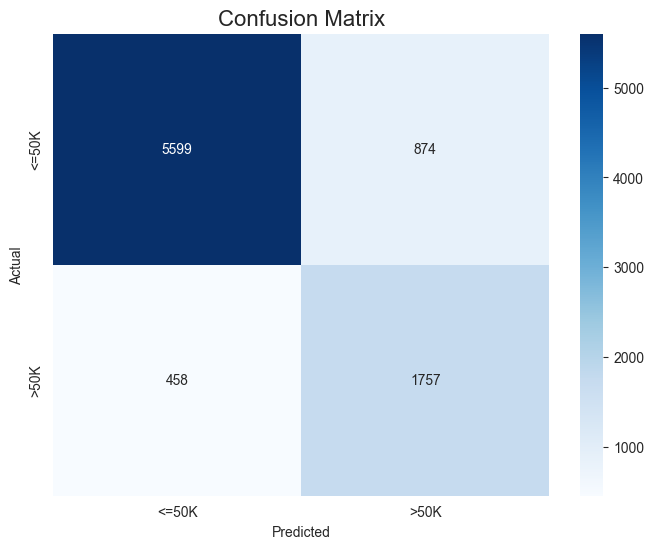

In [21]:
# 5. Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [22]:
# Save the final, tuned pipeline
joblib.dump(best_model, "tuned_salary_model_pipeline.pkl")
print("\n✅ Saved tuned model pipeline to 'tuned_salary_model_pipeline.pkl'")


✅ Saved tuned model pipeline to 'tuned_salary_model_pipeline.pkl'
